# AT&T Spam Detector

This projects aim is to help AT&T to find an automated way of detecting spams to protect their users.


The goal is to build a spam detector, that can automatically flag spams as they come based solely on the sms' content.

### Import libraries

In [6]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import os
import io

### Import Data

In [7]:
## The separator is a regex expression that only grabs the first comma and is needed because otherwise the messages are split in several columns
data = pd.read_csv("./spam.csv", encoding="WINDOWS-1252", sep='^([^,]+),', engine="python")
data = data.drop("Unnamed: 0", axis=1)
data.columns = ["target", "full_sms"]
data.head()

,target,full_sms
0,ham,"""Go until jurong point, crazy.. Available only..."
1,ham,"Ok lar... Joking wif u oni...,,,"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"""Nah I don't think he goes to usf, he lives ar..."


The data is composed of flags (wheater the sms is spam or not) and the sms' themselves. As expected, the data is very messy, with a lot of puntuation, abreviations and other types of noise. This needs to be adressed

In [9]:
data.target.value_counts()

ham       4825
spam       747
ham"""       2
Name: target, dtype: int64

In [10]:
data.loc[:,"target"] = data.loc[:,"target"].apply(lambda x: x.replace('\"\"\"', ''))
data.target.value_counts()

ham     4827
spam     747
Name: target, dtype: int64

In the two cells above I am just cleaning the target variable since we have some quotes in at two different lines. 

Next I just encode the target varaible for later.

In [11]:
def target_encode(x):
    if x == 'ham':
        return 1
    else:
        return 0

data['target'] = data.target.apply(lambda x: target_encode(x))
data.head()

,target,full_sms
0,1,"""Go until jurong point, crazy.. Available only..."
1,1,"Ok lar... Joking wif u oni...,,,"
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"""Nah I don't think he goes to usf, he lives ar..."


In the following I focus on cleaning and transforming the sms text into lemmatized tokens.

In [12]:
!python -m spacy download en_core_web_md

2024-01-31 10:35:05.012307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 10:35:05.012364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 10:35:05.013602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 10:35:06.028650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 19.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [13]:
import spacy
import en_core_web_md
from spacy.lang.en.stop_words import STOP_WORDS
nlp = en_core_web_md.load()

data["clean_sms"] = data['full_sms'].apply(lambda x: ''.join(char for char in x if char.isalnum() or char==' '))
data['clean_sms'] = data['clean_sms'].apply(lambda x : x.replace(" +", " ").lower().strip())
data['clean_sms'] = data['clean_sms'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
data

,target,full_sms,clean_sms
0,1,"""Go until jurong point, crazy.. Available only...",jurong point crazy available bugis n great wor...
1,1,"Ok lar... Joking wif u oni...,,,",ok lar joke wif u oni
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,1,U dun say so early hor... U c already then say...,u dun early hor u c
4,1,"""Nah I don't think he goes to usf, he lives ar...",nah think usf live
...,...,...,...
5569,0,"""This is the 2nd time we have tried 2 contact ...",2nd time try 2 contact u u win å750 pound priz...
5570,1,"Will Ì_ b going to esplanade fr home?,,,",ì b esplanade fr home
5571,1,"""Pity, * was in mood for that. So...any other ...",pity mood soany suggestion
5572,1,The guy did some bitching but I acted like i'd...,guy bitching act like d interested buy week free


Then I can encode the text into lists of numbers !

In [14]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="<out_of_vocab>")

In [15]:
tokenizer.fit_on_texts(data.clean_sms)
data["sms_encoded"] = tokenizer.texts_to_sequences(data.clean_sms)
data.head()

,target,full_sms,clean_sms,sms_encoded
0,1,"""Go until jurong point, crazy.. Available only...",jurong point crazy available bugis n great wor...,"[1, 235, 449, 463, 943, 36, 54, 208, 944, 79, ..."
1,1,"Ok lar... Joking wif u oni...,,,",ok lar joke wif u oni,"[11, 196, 464, 290, 2, 1]"
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[13, 302, 4, 534, 663, 33, 1, 851, 426, 1, 1, ..."
3,1,U dun say so early hor... U c already then say...,u dun early hor u c,"[2, 126, 150, 1, 2, 86]"
4,1,"""Nah I don't think he goes to usf, he lives ar...",nah think usf live,"[711, 23, 664, 131]"


In [16]:
data['len'] = data.sms_encoded.apply(lambda x: len(x))
data = data[data['len'] != 0]

In [21]:
tokenizer.index_word

{1: '<out_of_vocab>',
 2: 'u',
 3: 'm',
 4: '2',
 5: 'ur',
 6: 'come',
 7: 's',
 8: '4',
 9: 'know',
 10: 'good',
 11: 'ok',
 12: 'ltgt',
 13: 'free',
 14: 'send',
 15: 'like',
 16: 'want',
 17: 'day',
 18: 'ill',
 19: 'time',
 20: 'love',
 21: 'text',
 22: 'tell',
 23: 'think',
 24: 'need',
 25: 'txt',
 26: 'home',
 27: 'lor',
 28: 'stop',
 29: 'reply',
 30: 'd',
 31: 'sorry',
 32: 'r',
 33: 'win',
 34: 'mobile',
 35: 'today',
 36: 'n',
 37: 'phone',
 38: 'new',
 39: 'week',
 40: 'work',
 41: 'later',
 42: 'hi',
 43: 'ask',
 44: 'da',
 45: 'miss',
 46: 'ì',
 47: 'night',
 48: 'hope',
 49: 'try',
 50: 'claim',
 51: 'meet',
 52: 'wait',
 53: 'thing',
 54: 'great',
 55: 'oh',
 56: 'leave',
 57: 'hey',
 58: 'dear',
 59: 'pls',
 60: 'happy',
 61: 'wat',
 62: 'message',
 63: 'number',
 64: 'friend',
 65: 'feel',
 66: 'thank',
 67: 'way',
 68: 've',
 69: 'late',
 70: 'prize',
 71: 'right',
 72: 'msg',
 73: 'find',
 74: 'pick',
 75: 'tomorrow',
 76: 'yes',
 77: 'let',
 78: 'yeah',
 79: 'e',
 

Finally the encoded text needs to be padded so as to be the same length for the model.

In [22]:
data_paded = tf.keras.preprocessing.sequence.pad_sequences(data.sms_encoded, padding="post")

Now I just split the data into train, test and validation sets. 

In [23]:
xtrain, xvaltest, ytrain, yvaltest = train_test_split(data_paded, data.target, test_size=0.4, stratify=data.target)
xtest, xval, ytest, yval = train_test_split(xvaltest, yvaltest, test_size=0.2, stratify=yvaltest)

In [24]:
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val_ds = tf.data.Dataset.from_tensor_slices((xval, yval))
test_ds = tf.data.Dataset.from_tensor_slices((xtest, ytest))

In [25]:
train_batch = train_ds.shuffle(len(train_ds)).batch(64)
val_batch = val_ds.shuffle(len(val_ds)).batch(64)
test_batch = test_ds.shuffle(len(test_ds)).batch(64)

In [26]:
sms, target = next(iter(train_batch))
print(sms, target)

tf.Tensor(
[[  1   4  12 ...   0   0   0]
 [  1  65   1 ...   0   0   0]
 [612 256 180 ...   0   0   0]
 ...
 [ 74   1   1 ...   0   0   0]
 [  1   1 417 ...   0   0   0]
 [ 57 425   2 ...   0   0   0]], shape=(64, 72), dtype=int32) tf.Tensor(
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0
 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1], shape=(64,), dtype=int64)


### Modeling

Now for the modelling. The model will have an emmbeding layer (16 dimensions) followed by a global average pooling and ending with two dense layers, one of them being the prediction layer.

In [29]:
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

embedding_dim = 16
vocab_size = tokenizer.num_words

model = tf.keras.Sequential([
    Embedding(vocab_size+1, embedding_dim, input_shape=[sms.shape[1],], name="embedding"),
    GlobalAveragePooling1D(),
    Dense(16, activation="relu"),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 16)            16016     
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 16305 (63.69 KB)
Trainable params: 16305 (63.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Define the model's optimizer, loss and metrics.

In [30]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall

model.compile(optimizer = Adam(),
              loss = BinaryCrossentropy(),
              metrics=[BinaryAccuracy(name = 'accuracy'), Precision(name = 'precision'), Recall(name = 'recall')])


Define the class weights

In [31]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(data.target),
                                                 y = data.target)

class_weights = dict(zip(np.unique(data.target), class_weights))
class_weights

{0: 3.718875502008032, 1: 0.577666874610106}

Train the model !

In [32]:
history = model.fit(train_batch, epochs=60, validation_data=val_batch, class_weight=class_weights)

Epoch 1/60
53/53 [==============================] - 10s 125ms/step - loss: 0.6899 - accuracy: 0.8644 - precision: 0.8712 - recall: 0.9896 - val_loss: 0.6767 - val_accuracy: 0.8742 - val_precision: 0.8799 - val_recall: 0.9896
Epoch 2/60
53/53 [==============================] - 3s 51ms/step - loss: 0.6802 - accuracy: 0.9061 - precision: 0.9165 - recall: 0.9809 - val_loss: 0.6556 - val_accuracy: 0.9011 - val_precision: 0.9231 - val_recall: 0.9662
Epoch 3/60
53/53 [==============================] - 2s 43ms/step - loss: 0.6565 - accuracy: 0.9295 - precision: 0.9434 - recall: 0.9771 - val_loss: 0.6095 - val_accuracy: 0.9169 - val_precision: 0.9531 - val_recall: 0.9506
Epoch 4/60
53/53 [==============================] - 2s 32ms/step - loss: 0.6104 - accuracy: 0.9421 - precision: 0.9610 - recall: 0.9726 - val_loss: 0.5477 - val_accuracy: 0.9169 - val_precision: 0.9652 - val_recall: 0.9377
Epoch 5/60
53/53 [==============================] - 1s 10ms/step - loss: 0.5401 - accuracy: 0.9457 - preci

Check the performance 

Text(0, 0.5, 'F1score')

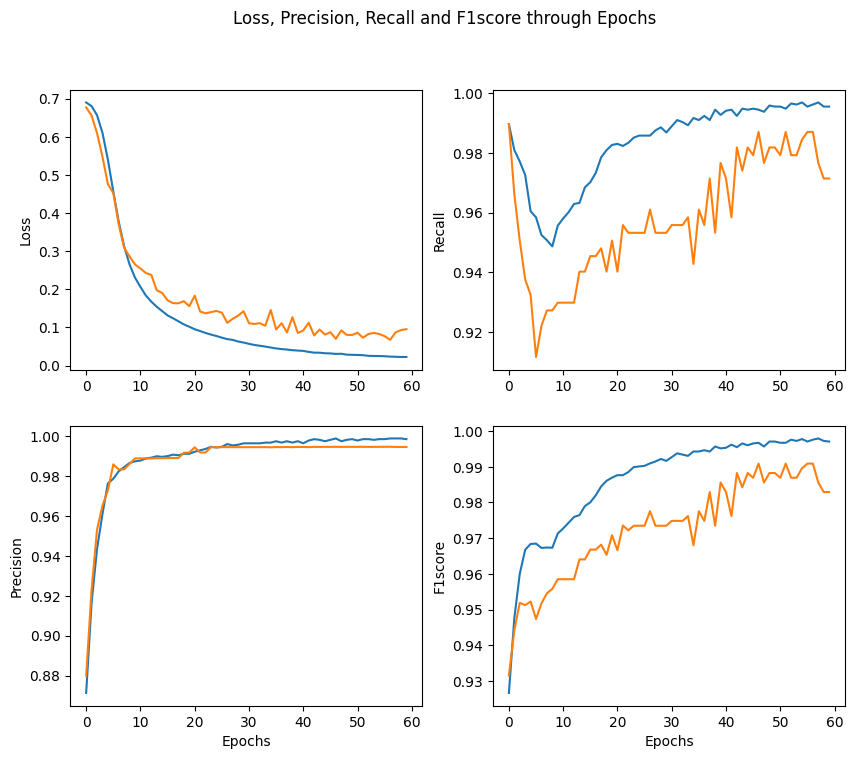

In [33]:
import matplotlib.pyplot as plt

def f1_score_computation(precision, recall):
    f1_score_list = []
    for (precision_score, recall_score) in zip(precision, recall):
        try:
            f1_score_list.append(2 * ((precision_score * recall_score) / (precision_score + recall_score)))
        except ZeroDivisionError:
            f1_score_list.append(np.nan)
    return f1_score_list

f1 = f1_score_computation(history.history['precision'], history.history['recall'])
val_f1 = f1_score_computation(history.history['val_precision'], history.history['val_recall'])


fig, axs = plt.subplots(2,2, figsize=(10,8))
fig.suptitle('Loss, Precision, Recall and F1score through Epochs')
axs[0,0].plot(history.history['loss'])
axs[0,0].plot(history.history['val_loss'])
axs[0,0].set_ylabel("Loss")

axs[1,0].plot(history.history['precision'])
axs[1,0].plot(history.history['val_precision'])
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Precision")

axs[0,1].plot(history.history['recall'])
axs[0,1].plot(history.history['val_recall'])
axs[0,1].set_ylabel("Recall")

axs[1,1].plot(f1)
axs[1,1].plot(val_f1)
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("F1score")

Given the results of this first model we can see that the loss is diminishing each epoch as exxpected but there seems to be some degree of overfitting. Although the precision is very good at the end of the training, the recall varies a lot and the impact onto the f1-score is clear. The model can be improved significantly. I will try to achieve better performances using transfer learning. 

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def model_eval(model, x, y):
    y_preds = np.round(model.predict(x))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1score = f1_score(y, y_preds)

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1-score': f1score}

model_eval(model, xtest, ytest)

56/56 [==============================] - 0s 2ms/step


{'accuracy': 0.9746906636670416,
 'precision': 0.987597911227154,
 'recall': 0.9831059129304743,
 'f1-score': 0.9853467925757082}

Overall the model is pretty good but overfitting light still be a problem

In [35]:
vocab = [value for value in tokenizer.index_word.values()]
vocab = vocab[:1000]
weights = model.get_layer('embedding').get_weights()[0]

log_dir = "./logs/"
os.makedirs(log_dir, exist_ok=True)
out_v = io.open(log_dir+"/vectors.tsv", 'w', encoding='utf-8')
out_m = io.open(log_dir+"/metadata.tsv", 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


In the code above I created a logs folder containing the vector and the metadata of the embedding model that can be visualized using [the embedding projector](https://projector.tensorflow.org/)

This simple model is already very good, but as it was trained on little data, it might be worth using transfer learning to improve predictions on future datasets.

### Transfer learning

In the following I will try to achieve better performances using transfer learning

In [36]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.7 MB/s eta 0:00:00


I decided to use the small bert model found on tensroflowhub. This model has already been trained on a much bigger dataset, and is optimized for classification problems. 

In [37]:
import tensorflow_hub as hub
import tensorflow_text as text

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/2",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]
sequence_output = outputs["sequence_output"]


In [ ]:
## This cell is only used to check that the first layer is well configured
embedding_model = tf.keras.Model(text_input, pooled_output)
sentences = tf.constant(["(your text here)"]) ### change
print(embedding_model(sentences))


tf.Tensor(
[[ 0.9929117   0.80310345 -0.5381706   0.4833545  -0.9758657  -0.66956353
   0.25451708  0.04606412 -0.44029513  0.9019176   0.98015463 -0.88252854
   0.13112347  0.4504974  -0.8969923  -0.18271136 -0.04136598  0.00614051
  -0.38667512  0.7073359  -0.86779654  0.9960004   0.79244447  0.9965769
  -0.7746326   0.8114333   0.06427079 -0.9605676   0.6500552   0.8557718
   0.8487226   0.93223    -0.00748214 -0.12899244  0.2558161   0.57133555
  -0.95821536 -0.9958449  -0.70812935 -0.9159619   0.66084754 -0.9043972
   0.9876591   0.02163612  0.6455754   0.9261782  -0.33330998 -0.9595995
  -0.47702393  0.96164304  0.8748242   0.7475906   0.976885   -0.8723229
   0.08858956 -0.82080317  0.7769756  -0.8229184  -0.12997161  0.9872259
   0.9464982   0.9604519  -0.25631145 -0.21122482 -0.05469976 -0.8740395
   0.08517809 -0.5832691  -0.9998633   0.09758935  0.9961059  -0.39020056
  -0.8861855  -0.96866304  0.9618963   0.92715627  0.07770768  0.9611806
  -0.17348744  0.81805116  0.975705

Her eI just add a new dropout layer to reduce overfititng and a final dense layer for prediciton

In [39]:
from tensorflow.keras.layers import Dropout
tl_model = tf.keras.Sequential([
    embedding_model,
    Dropout(rate=.1),
    Dense(1, "sigmoid")
])

In [40]:
tl_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 128)               6368641   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6368770 (24.29 MB)
Trainable params: 129 (516.00 Byte)
Non-trainable params: 6368641 (24.29 MB)
_________________________________________________________________


Define optimizer, loss and metrics

In [41]:
tl_model.compile(optimizer = Adam(),
              loss = BinaryCrossentropy(),
              metrics=[BinaryAccuracy(name = 'accuracy'), Precision(name = 'precision'), Recall(name = 'recall')])


split dataset

In [42]:
xtrain, xvaltest, ytrain, yvaltest = train_test_split(data.full_sms, data.target, test_size=0.4, stratify=data.target)
xtest, xval, ytest, yval = train_test_split(xvaltest, yvaltest, test_size=0.2, stratify=yvaltest)

train_ds = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val_ds = tf.data.Dataset.from_tensor_slices((xval, yval))
test_ds = tf.data.Dataset.from_tensor_slices((xtest, ytest))

train_batch = train_ds.shuffle(len(train_ds)).batch(64)
val_batch = val_ds.shuffle(len(val_ds)).batch(64)
test_batch = test_ds.shuffle(len(test_ds)).batch(64)

train last layer of the model

In [43]:
tl_history = tl_model.fit(train_batch, epochs=60, validation_data=val_batch, class_weight=class_weights)

Epoch 1/60
53/53 [==============================] - 34s 289ms/step - loss: 0.5889 - accuracy: 0.7072 - precision: 0.9421 - recall: 0.7050 - val_loss: 0.4871 - val_accuracy: 0.8629 - val_precision: 0.9793 - val_recall: 0.8597
Epoch 2/60
53/53 [==============================] - 14s 266ms/step - loss: 0.4653 - accuracy: 0.8344 - precision: 0.9725 - recall: 0.8322 - val_loss: 0.4196 - val_accuracy: 0.8652 - val_precision: 0.9909 - val_recall: 0.8519
Epoch 3/60
53/53 [==============================] - 14s 258ms/step - loss: 0.3936 - accuracy: 0.8539 - precision: 0.9827 - recall: 0.8461 - val_loss: 0.3352 - val_accuracy: 0.8966 - val_precision: 0.9913 - val_recall: 0.8883
Epoch 4/60
53/53 [==============================] - 14s 256ms/step - loss: 0.3461 - accuracy: 0.8749 - precision: 0.9874 - recall: 0.8666 - val_loss: 0.2979 - val_accuracy: 0.9056 - val_precision: 0.9914 - val_recall: 0.8987
Epoch 5/60
53/53 [==============================] - 15s 285ms/step - loss: 0.3174 - accuracy: 0.8857

Text(0, 0.5, 'F1score')

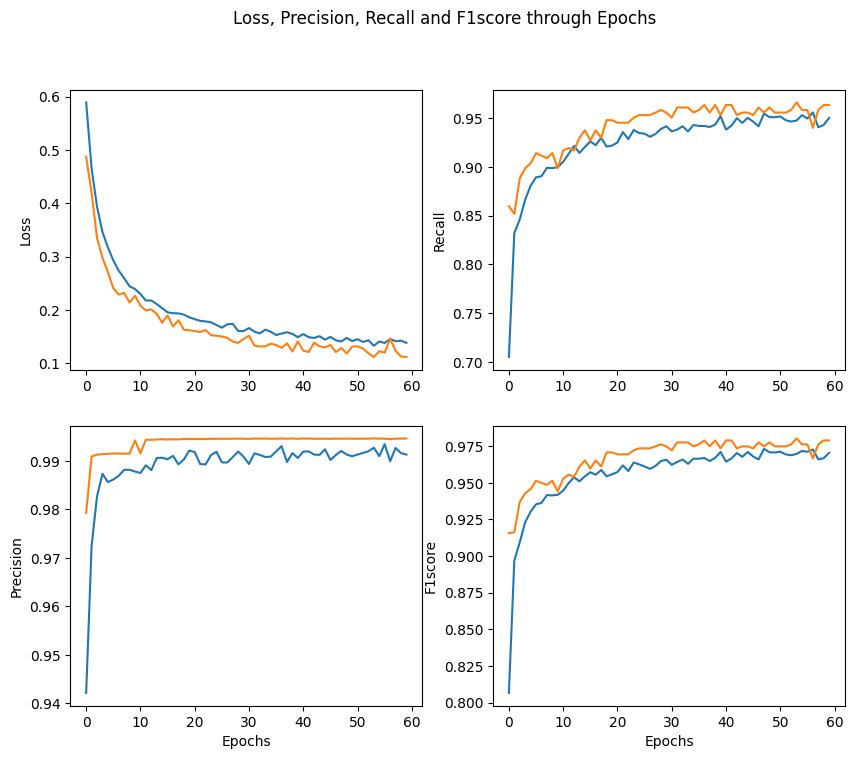

In [44]:
f1 = f1_score_computation(tl_history.history['precision'], tl_history.history['recall'])
val_f1 = f1_score_computation(tl_history.history['val_precision'], tl_history.history['val_recall'])

fig, axs = plt.subplots(2,2, figsize=(10,8))
fig.suptitle('Loss, Precision, Recall and F1score through Epochs')
axs[0,0].plot(tl_history.history['loss'])
axs[0,0].plot(tl_history.history['val_loss'])
axs[0,0].set_ylabel("Loss")

axs[1,0].plot(tl_history.history['precision'])
axs[1,0].plot(tl_history.history['val_precision'])
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Precision")

axs[0,1].plot(tl_history.history['recall'])
axs[0,1].plot(tl_history.history['val_recall'])
axs[0,1].set_ylabel("Recall")

axs[1,1].plot(f1)
axs[1,1].plot(val_f1)
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("F1score")

Compared to the custome model made earlier, the transfer learning bert model seems to have better performances based ont the f1-scores across epochs. 

At the very least the recall values are much more stable, and I would personnally prefer this model for spam detection. 